# Codebase 5: Final Analysis & Interpretation

This section performs th final analysis and interpretation of the holdout results in the following sections:

1. Undersampling
2. Oversampling
3. Class Weights
4. Threshold Testing
5. Ensembles
6. Holdout Set Results (NLP, FIN, MKT)
7. Drawdown by Confusion Matrix
8. NLP Interpretation

## 1. Undersampling

### 1.1 Undersampling: Summary Results Table

In [1]:
import pandas as pd
import numpy as np
import pickle

time_series_meth = ['random', 'eq_num_year']
features_meth = ['tfidf', 'sector_dummies', 'lag_quartile']

model_names = ['RANDOM', 'EQ_NUM_YEAR', 'SECTOR_DUMMIES' ]
filenames = ['dict_cv_undersample_random_TfidfVectorizer_min_df_25_unigram.pickle',
             'dict_cv_undersample_equal_num_TfidfVectorizer_min_df_25_unigram.pickle',
             'dict_cv_undersample_equal_num_DUMMIES_TfidfVectorizer_min_df_25_unigram.pickle']

cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
algo_grid = ['grad_boost', 'random_forest', 'log_reg']
score_grid =['mh_recall', 'pos_recall', 'neg_recall']

output_filename = 'consolidate_cv_summary_results_undersample_by_model.pickle'


  
dict_under = { model_names[0]:{}, model_names[1]:{}, model_names[2]:{}}

#create dictionary
for algo in algo_grid:
     dict_under[model_names[0]].update({algo: {}}) 
     dict_under[model_names[1]].update({algo: {}}) 
     dict_under[model_names[2]].update({algo: {}}) 
 
     
     for score in score_grid:
         dict_under[model_names[0]][algo].update({score: np.nan})  
         dict_under[model_names[1]][algo].update({score: np.nan}) 
         dict_under[model_names[2]][algo].update({score: np.nan}) 
   



#populate dictionary
for idx_file, file in enumerate(filenames):
    d = pd.read_pickle(file)
    model = model_names[idx_file] 


    for algo in algo_grid:
        recall_neg = 0
        recall_pos = 0
        macro_harmonic_recall = 0

        for idx, cv in enumerate(cv_grid):
            
            w = (idx+1) / 10 
            
            cm1 = d[cv][algo]['conf_matrix']
            recall_pos1 = cm1[1,1] / (cm1[1,0] + cm1[1,1])
            recall_neg1 = cm1[0,0] / (cm1[0,0] + cm1[0,1])
            macro_harmonic_recall_1 = 2*recall_pos1*recall_neg1 / (recall_pos1 + recall_neg1)

            
            recall_neg = recall_neg + w*recall_neg1
            recall_pos = recall_pos + w*recall_pos1
            macro_harmonic_recall =  macro_harmonic_recall + w* macro_harmonic_recall_1
        
        
        
        
        dict_under[model][algo]['pos_recall'] = round(recall_pos,2)
        dict_under[model][algo]['neg_recall'] = round(recall_neg,2)
        dict_under[model][algo]['mh_recall'] = round(macro_harmonic_recall,2)

  
df_random = pd.DataFrame.from_dict(dict_under[model_names[0]], orient='index')
df_eq_num_year = pd.DataFrame.from_dict(dict_under[model_names[1]], orient='index')
df_sector_dummies = pd.DataFrame.from_dict(dict_under[model_names[2]], orient='index')




df_random.columns.name = model_names[0]
df_eq_num_year.columns.name = model_names[1]
df_sector_dummies.columns.name = model_names[2]



dict_final = { model_names[0]: df_random,
              model_names[1]: df_eq_num_year,
              model_names[2]: df_sector_dummies} 

with open(output_filename, 'wb') as handle:                                     
    pickle.dump(dict_final, handle, protocol=pickle.HIGHEST_PROTOCOL)          

print('\033[1m{:10s}\033[0m'.format('CV Summary Results: '))  
print('')        
print(dict_final[model_names[0]])
print('')        
print(dict_final[model_names[1]])
print('')        
print(dict_final[model_names[2]])



CV Summary Results: 

RANDOM         mh_recall  pos_recall  neg_recall
grad_boost          0.62        0.69        0.62
random_forest       0.58        0.73        0.52
log_reg             0.55        0.61        0.54

EQ_NUM_YEAR    mh_recall  pos_recall  neg_recall
grad_boost          0.66        0.76        0.58
random_forest       0.61        0.77        0.51
log_reg             0.58        0.55        0.64

SECTOR_DUMMIES  mh_recall  pos_recall  neg_recall
grad_boost           0.66        0.76        0.58
random_forest        0.62        0.78        0.51
log_reg              0.55        0.52        0.59


###  1.2 Undersampling: Plotting Scores by Model

<Figure size 432x216 with 0 Axes>

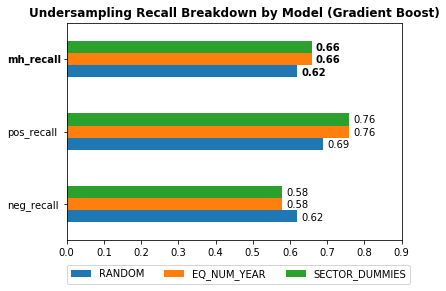

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

input_filename = 'consolidate_cv_summary_results_undersample_by_model.pickle'
models = ['RANDOM', 'EQ_NUM_YEAR', 'SECTOR_DUMMIES']

d = pd.read_pickle(input_filename)

# bar plot all recall by model ################################################
adj_models = ['RANDOM', 'EQ_NUM_YEAR', 'SECTOR_DUMMIES']
counter=0
for model in adj_models:
    s = d[model].loc['grad_boost',:].transpose()
    s.index.name=''
    s.name = model
    
    if counter==0:
        s_final = s
    else:
        s_final = pd.concat([s_final,s], axis=1)
    counter += 1

index_order = reversed(s_final.index.tolist())
s_final = s_final.reindex(index_order)

plt.figure(figsize=(6,3));
s_final.plot(kind='barh')

for num in [0, 1]:
    s = s_final.iloc[num,:]
    y = reversed(list(s.values))
    for i, y in enumerate(y):
        plt.text(y+0.01, num + 0.16 - i/5.8, '{:.2f}'.format(y), va='center');
        
for num in [2]:
    s = s_final.iloc[num,:]
    y = reversed(list(s.values))
    for i, y in enumerate(y):
        plt.text(y+0.01, num + 0.16 - i/5.8, '{:.2f}'.format(y), fontweight='bold', va='center');
        
plt.yticks(color='w');
plt.text(-0.16,2-0.045,'mh_recall', fontweight='bold');
plt.text(-0.16,1-0.045,'pos_recall');
plt.text(-0.16,0-0.045,'neg_recall');

plt.legend(loc=(0.0,-0.2), ncol=3);
plt.xlim((0,0.9));
plt.title('Undersampling Recall Breakdown by Model (Gradient Boost)', fontweight='bold');

### 1.3 Undersampling: Plotting Scores by Algo

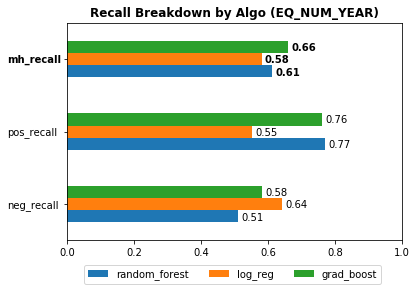

In [3]:
# bar plot all recall by algo #################################################
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

input_filename = 'consolidate_cv_summary_results_undersample_by_model.pickle'
models = ['RANDOM', 'EQ_NUM_YEAR', 'SECTOR_DUMMIES']

d = pd.read_pickle(input_filename)
algos = ['random_forest', 'log_reg', 'grad_boost']
counter=0
for algo in algos:
    s = d['EQ_NUM_YEAR'].loc[algo,:].transpose()
    s.index.name=''
    s.name = algo
    
    if counter==0:
        s_final = s
    else:
        s_final = pd.concat([s_final,s], axis=1)
    counter += 1
    
index_order = reversed(s_final.index.tolist())
s_final = s_final.reindex(index_order)
s_final.plot(kind='barh')

for num in [0, 1]:
    s = s_final.iloc[num,:]
    y = reversed(list(s.values))
    for i, y in enumerate(y):
        plt.text(y+0.01, num + 0.16 - i/5.8, '{:.2f}'.format(y), va='center');
        
for num in [2]:
    s = s_final.iloc[num,:]
    y = reversed(list(s.values))
    for i, y in enumerate(y):
        plt.text(y+0.01, num + 0.16 - i/5.8, '{:.2f}'.format(y), fontweight='bold', va='center');

plt.yticks(color='w')
plt.text(-0.18,2-0.045,'mh_recall', fontweight='bold')
plt.text(-0.18,1-0.045,'pos_recall')
plt.text(-0.18,0-0.045,'neg_recall')
        
plt.legend(loc=(0.05,-0.2), ncol=3);
plt.xlim((0,1));
plt.title('Recall Breakdown by Algo (EQ_NUM_YEAR)', fontweight='bold');

## 2. Oversampling

### Oversampling: Summary Results Table

In [4]:
import pickle
import pandas as pd
import numpy as np

cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
algo_grid = ['grad_boost', 'random_forest', 'log_reg'] #['grad_boost', 'random_forest', 'log_reg']
numbers = [2,3,5] 
number_grid= list(map(lambda x: 'NUMBER_'+str(x), numbers))
score_grid =['mh_recall', 'pos_recall', 'neg_recall']

output_filename = 'consolidate_cv_summary_results_oversample_by_number.pickle'


dict_under={}  
for number in number_grid:
    dict_under.update({ number:{}})

    for algo in algo_grid:
        dict_under[number].update({algo: {}}) 

        for score in score_grid:
            dict_under[number][algo].update({score: np.nan})  


#populate dictionary
filename = 'dict_cv_oversample_equal_num_TfidfVectorizer_min_df_25_number_ratios_unigram.pickle'
d = pd.read_pickle(filename)

for number in number_grid:
    key_number = number.lower().replace('_', '') 
    for algo in algo_grid:
        recall_neg = 0
        recall_pos = 0
        macro_harmonic_recall = 0

        for idx, cv in enumerate(cv_grid):
            
            w = (idx+1) / 10 
            
            cm1 = d[cv][key_number][algo]['conf_matrix']
            recall_pos1 = cm1[1,1] / (cm1[1,0] + cm1[1,1])
            recall_neg1 = cm1[0,0] / (cm1[0,0] + cm1[0,1])
            macro_harmonic_recall_1 = 2*recall_pos1*recall_neg1 / (recall_pos1 + recall_neg1)

            
            recall_neg = recall_neg + w*recall_neg1
            recall_pos = recall_pos + w*recall_pos1
            macro_harmonic_recall =  macro_harmonic_recall + w* macro_harmonic_recall_1
            
        dict_under[number][algo]['pos_recall'] = round(recall_pos,2)
        dict_under[number][algo]['neg_recall'] = round(recall_neg,2)
        dict_under[number][algo]['mh_recall'] = round(macro_harmonic_recall,2)
        
df_num_2 = pd.DataFrame.from_dict(dict_under[number_grid[0]], orient='index')
df_num_3 = pd.DataFrame.from_dict(dict_under[number_grid[1]], orient='index')
df_num_5 = pd.DataFrame.from_dict(dict_under[number_grid[2]], orient='index')

df_num_2.columns.name = number_grid[0]
df_num_3.columns.name = number_grid[1]
df_num_5.columns.name = number_grid[2]

dict_final = { number_grid[0]: df_num_2,
              number_grid[1]: df_num_3,
              number_grid[2]: df_num_5} 

with open(output_filename, 'wb') as handle:                                     
    pickle.dump(dict_final, handle, protocol=pickle.HIGHEST_PROTOCOL)          

print('\033[1m{:10s}\033[0m'.format('CV Summary Results: '))  
print('')        
print(dict_final[number_grid[0]])
print('')        
print(dict_final[number_grid[1]])
print('')        
print(dict_final[number_grid[2]])


CV Summary Results: 

NUMBER_2       mh_recall  pos_recall  neg_recall
grad_boost          0.64        0.55        0.77
random_forest       0.42        0.28        0.91
log_reg             0.52        0.40        0.76

NUMBER_3       mh_recall  pos_recall  neg_recall
grad_boost          0.63        0.54        0.79
random_forest       0.24        0.14        0.97
log_reg             0.51        0.38        0.80

NUMBER_5       mh_recall  pos_recall  neg_recall
grad_boost          0.60        0.49        0.82
random_forest       0.07        0.03        1.00
log_reg             0.45        0.31        0.85


###  1.2 Oversampling: Plotting Scores by Algo

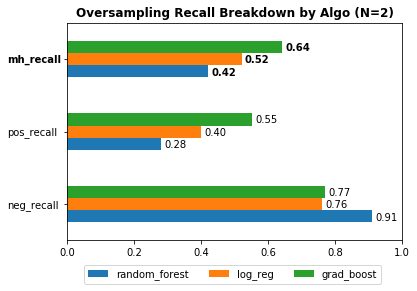

In [5]:
# bar plot all recall by algo #################################################
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

input_filename = 'consolidate_cv_summary_results_oversample_by_number.pickle'
models = ['RANDOM', 'EQ_NUM_YEAR', 'SECTOR_DUMMIES']

d = pd.read_pickle(input_filename)
algos = ['random_forest', 'log_reg', 'grad_boost']
counter=0
for algo in algos:
    s = d['NUMBER_2'].loc[algo,:].transpose()
    s.index.name=''
    s.name = algo
    
    if counter==0:
        s_final = s
    else:
        s_final = pd.concat([s_final,s], axis=1)
    counter += 1
    
index_order = reversed(s_final.index.tolist())
s_final = s_final.reindex(index_order)
s_final.plot(kind='barh')

for num in [0, 1]:
    s = s_final.iloc[num,:]
    y = reversed(list(s.values))
    for i, y in enumerate(y):
        plt.text(y+0.01, num + 0.16 - i/5.8, '{:.2f}'.format(y), va='center');
        
for num in [2]:
    s = s_final.iloc[num,:]
    y = reversed(list(s.values))
    for i, y in enumerate(y):
        plt.text(y+0.01, num + 0.16 - i/5.8, '{:.2f}'.format(y), fontweight='bold', va='center');

plt.yticks(color='w')
plt.text(-0.18,2-0.045,'mh_recall', fontweight='bold')
plt.text(-0.18,1-0.045,'pos_recall')
plt.text(-0.18,0-0.045,'neg_recall')
        
plt.legend(loc=(0.05,-0.2), ncol=3);
plt.xlim((0,1));
plt.title('Oversampling Recall Breakdown by Algo (N=2)', fontweight='bold');

In [6]:
d['NUMBER_2']['mh_recall'].keys()


Index(['grad_boost', 'random_forest', 'log_reg'], dtype='object')

## 3. Class Weights

In [7]:
import pandas as pd

file_cw = 'dict_cv_class_weights_equal_num_TfidfVectorizer_min_df_25_unigram.pickle'
d_cw = pd.read_pickle(file_cw)
cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']

agg_cm1 = 0
agg_cm2 = 0
agg_cm3 = 0
for cv in cv_grid:

    cm1 = d_cw[cv]['grad_boost']['conf_matrix']
    cm2 = d_cw[cv]['random_forest_balanced_cw_none']['conf_matrix']
    cm3 = d_cw[cv]['random_forest_cw_balanced']['conf_matrix']
    
    agg_cm1 = agg_cm1 + cm1
    agg_cm2 = agg_cm2 + cm2
    agg_cm3 = agg_cm3 + cm3


df1 = pd.DataFrame(agg_cm1, index= ['True_Neg', 'True_Pos'], columns=['Pred_Neg', 'Pred_Pos'])
df1.columns.name = 'GRAD_BOOST'

df2 = pd.DataFrame(agg_cm2, index= ['True_Neg', 'True_Pos'], columns=['Pred_Neg', 'Pred_Pos'])
df2.columns.name = 'RANDOM FOREST NONE'

df3 = pd.DataFrame(agg_cm3, index= ['True_Neg', 'True_Pos'], columns=['Pred_Neg', 'Pred_Pos'])
df3.columns.name = 'RANDOM FOREST CW BALANCED'

print('\033[1m{:10s}\033[0m'.format('Aggregate CV Confusion Matrices: ')) 
print('')
print(df1)
print('')
print(df2)
print('')
print(df3)

Aggregate CV Confusion Matrices: 

GRAD_BOOST  Pred_Neg  Pred_Pos
True_Neg       22744       767
True_Pos         823       122

RANDOM FOREST NONE  Pred_Neg  Pred_Pos
True_Neg               23479        32
True_Pos                 939         6

RANDOM FOREST CW BALANCED  Pred_Neg  Pred_Pos
True_Neg                      23501        10
True_Pos                        943         2


## 4. Threshold Testing

### 4.1 Undersample

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

f_under = 'dict_cv_undersample_equal_num_TfidfVectorizer_min_df_25_unigram.pickle'

thresh_grid = [0.65,0.6, 0.55, 0.50, 0.45]

cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
score_grid =['mh_recall', 'pos_recall', 'neg_recall']
algos = ['grad_boost','random_forest', 'log_reg']
d_under = pd.read_pickle(f_under)


dict_results = {}
dict_std ={}
#Create dictionary 
for algo in algos:
    dict_results.update({algo: {}})
    dict_std.update({algo: {}})  
    for thresh in thresh_grid:
        dict_results[algo].update({thresh: {}})
        dict_std[algo].update({thresh: {}})
        for score in score_grid:
            dict_results[algo][thresh].update({score: np.nan})
            dict_std[algo][thresh].update({score: np.nan})
            
#Populate dictionary
for algo in algos:
    for thresh in thresh_grid: 
        log_thresh = np.log(thresh)
    
        thresh_w_cv_mh_list = []
        thresh_w_cv_pos_list = []
        thresh_w_cv_neg_list = []
    
        mh_recall = 0 
        pos_recall = 0
        neg_recall = 0
    
        for i, cv in enumerate(cv_grid): 
        
            w_cv = (i+1)/10
        
            y_log_prob_under = np.log(d_under[cv][algo]['y_proba'][:,1])
            y_test = d_under[cv][algo]['y_test']
            y_pred = (y_log_prob_under > log_thresh)*1

            cm = confusion_matrix(y_test, y_pred)
            pos_recall_1 = cm[1,1] / (cm[1,0] + cm[1,1])
            neg_recall_1 = cm[0,0] / (cm[0,0] + cm[0,1])
            mh_recall_1 = 2*pos_recall_1*neg_recall_1 / (pos_recall_1 + neg_recall_1)
            
            mh_recall = mh_recall + w_cv*mh_recall_1
            pos_recall = pos_recall + w_cv*pos_recall_1
            neg_recall = neg_recall + w_cv*neg_recall_1
            

            thresh_w_cv_mh_list.append(mh_recall_1)
            thresh_w_cv_pos_list.append(pos_recall_1)
            thresh_w_cv_neg_list.append(neg_recall_1)
        
        dict_results[algo][thresh]['pos_recall'] = round(pos_recall,2)
        dict_results[algo][thresh]['neg_recall'] = round(neg_recall,2)
        dict_results[algo][thresh]['mh_recall'] = round(mh_recall,3)
            
        std_thresh_w_mh = np.std(thresh_w_cv_mh_list) 
        std_thresh_w_pos = np.std(thresh_w_cv_pos_list) 
        std_thresh_w_neg = np.std(thresh_w_cv_neg_list) 
    
        dict_std[algo][thresh]['pos_recall'] = round(std_thresh_w_pos,4)
        dict_std[algo][thresh]['neg_recall'] = round(std_thresh_w_neg,4)
        dict_std[algo][thresh]['mh_recall'] = round(std_thresh_w_mh,4)


df_algo1 = pd.DataFrame.from_dict(dict_results[algos[0]], orient='index')
df_algo1.index = map(lambda x: 'thresh_'+'{:.0%}'.format(x), df_algo1.index.tolist())
df_algo1.columns.name = 'GRAD BOOST'

df_algo2 = pd.DataFrame.from_dict(dict_results[algos[1]], orient='index')
df_algo2.index = map(lambda x: 'thresh_'+'{:.0%}'.format(x), df_algo2.index.tolist())
df_algo2.columns.name = 'RANDOM FOREST'

df_algo3 = pd.DataFrame.from_dict(dict_results[algos[2]], orient='index')
df_algo3.index = map(lambda x: 'thresh_'+'{:.0%}'.format(x), df_algo3.index.tolist())
df_algo3.columns.name = 'LOG REG'



print('\033[1m{:10s}\033[0m'.format('UNDERSAMPLING Summary Results: '))  
print('')   
print(df_algo1)
print('')   
print(df_algo2)
print('')   
print(df_algo3)


UNDERSAMPLING Summary Results: 

GRAD BOOST  mh_recall  pos_recall  neg_recall
thresh_65%      0.647        0.57        0.76
thresh_60%      0.673        0.65        0.70
thresh_55%      0.671        0.71        0.64
thresh_50%      0.656        0.76        0.58
thresh_45%      0.623        0.81        0.51

RANDOM FOREST  mh_recall  pos_recall  neg_recall
thresh_65%         0.296        0.18        0.94
thresh_60%         0.512        0.37        0.85
thresh_55%         0.641        0.60        0.70
thresh_50%         0.609        0.77        0.51
thresh_45%         0.480        0.88        0.33

LOG REG     mh_recall  pos_recall  neg_recall
thresh_65%      0.188        0.10        0.96
thresh_60%      0.331        0.20        0.89
thresh_55%      0.493        0.36        0.79
thresh_50%      0.583        0.55        0.64
thresh_45%      0.525        0.74        0.42


C:\Users\gslicht\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


### 4.2 Oversample

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

f_over = 'dict_cv_oversample_equal_num_TfidfVectorizer_min_df_25_number_ratios_unigram.pickle'

thresh_grid = [0.55,0.5, 0.45, 0.40, 0.35, 0.3]

cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
score_grid =['mh_recall', 'pos_recall', 'neg_recall']
algos = ['grad_boost','random_forest', 'log_reg']
n = 2
number = 'number' + str(n)
d_under = pd.read_pickle(f_over)


dict_results = {}
dict_std ={}
#Create dictionary 
for algo in algos:
    dict_results.update({algo: {}})
    dict_std.update({algo: {}})  
    for thresh in thresh_grid:
        dict_results[algo].update({thresh: {}})
        dict_std[algo].update({thresh: {}})
        for score in score_grid:
            dict_results[algo][thresh].update({score: np.nan})
            dict_std[algo][thresh].update({score: np.nan})
            
#Populate dictionary
for algo in algos:
    for thresh in thresh_grid: 
        log_thresh = np.log(thresh)
    
        thresh_w_cv_mh_list = []
        thresh_w_cv_pos_list = []
        thresh_w_cv_neg_list = []
    
        mh_recall = 0 
        pos_recall = 0
        neg_recall = 0
    
        for i, cv in enumerate(cv_grid): 
        
            w_cv = (i+1)/10
        
            y_log_prob_under = np.log(d_under[cv][number][algo]['y_proba'][:,1])
            y_test = d_under[cv][number][algo]['y_test']
            y_pred = (y_log_prob_under > log_thresh)*1

            cm = confusion_matrix(y_test, y_pred)
            pos_recall_1 = cm[1,1] / (cm[1,0] + cm[1,1])
            neg_recall_1 = cm[0,0] / (cm[0,0] + cm[0,1])
            mh_recall_1 = 2*pos_recall_1*neg_recall_1 / (pos_recall_1 + neg_recall_1)
            
            mh_recall = mh_recall + w_cv*mh_recall_1
            pos_recall = pos_recall + w_cv*pos_recall_1
            neg_recall = neg_recall + w_cv*neg_recall_1
            

            thresh_w_cv_mh_list.append(mh_recall_1)
            thresh_w_cv_pos_list.append(pos_recall_1)
            thresh_w_cv_neg_list.append(neg_recall_1)
        
        dict_results[algo][thresh]['pos_recall'] = round(pos_recall,2)
        dict_results[algo][thresh]['neg_recall'] = round(neg_recall,2)
        dict_results[algo][thresh]['mh_recall'] = round(mh_recall,3)
            
        std_thresh_w_mh = np.std(thresh_w_cv_mh_list) 
        std_thresh_w_pos = np.std(thresh_w_cv_pos_list) 
        std_thresh_w_neg = np.std(thresh_w_cv_neg_list) 
    
        dict_std[algo][thresh]['pos_recall'] = round(std_thresh_w_pos,4)
        dict_std[algo][thresh]['neg_recall'] = round(std_thresh_w_neg,4)
        dict_std[algo][thresh]['mh_recall'] = round(std_thresh_w_mh,4)


df_algo1 = pd.DataFrame.from_dict(dict_results[algos[0]], orient='index')
df_algo1.index = map(lambda x: 'thresh_'+'{:.0%}'.format(x), df_algo1.index.tolist())
df_algo1.columns.name = 'GRAD BOOST'

df_algo2 = pd.DataFrame.from_dict(dict_results[algos[1]], orient='index')
df_algo2.index = map(lambda x: 'thresh_'+'{:.0%}'.format(x), df_algo2.index.tolist())
df_algo2.columns.name = 'RANDOM FOREST'

df_algo3 = pd.DataFrame.from_dict(dict_results[algos[2]], orient='index')
df_algo3.index = map(lambda x: 'thresh_'+'{:.0%}'.format(x), df_algo3.index.tolist())
df_algo3.columns.name = 'LOG REG'



print('\033[1m{:10s}\033[0m'.format('OVERSAMPLING CV Summary Results for N = 2: '))  
print('')   
print(df_algo1)
print('')   
print(df_algo2)
print('')   
print(df_algo3)

C:\Users\gslicht\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


OVERSAMPLING CV Summary Results for N = 2: 

GRAD BOOST  mh_recall  pos_recall  neg_recall
thresh_55%      0.597        0.47        0.82
thresh_50%      0.636        0.55        0.77
thresh_45%      0.660        0.62        0.71
thresh_40%      0.664        0.70        0.64
thresh_35%      0.644        0.76        0.56
thresh_30%      0.590        0.83        0.46

RANDOM FOREST  mh_recall  pos_recall  neg_recall
thresh_55%         0.234        0.14        0.97
thresh_50%         0.421        0.28        0.91
thresh_45%         0.589        0.47        0.80
thresh_40%         0.655        0.68        0.64
thresh_35%         0.578        0.83        0.45
thresh_30%         0.414        0.91        0.27

LOG REG     mh_recall  pos_recall  neg_recall
thresh_55%      0.418        0.28        0.85
thresh_50%      0.519        0.40        0.76
thresh_45%      0.591        0.55        0.65
thresh_40%      0.584        0.71        0.50
thresh_35%      0.454        0.85        0.31
thresh_30%  

## 5. Ensembles

### 5.1  Ensemble Undersampling

In [10]:
import numpy as np
import pandas as pd

f_under = 'dict_cv_undersample_equal_num_TfidfVectorizer_min_df_25_unigram.pickle'


thresh_grid = [0.60, 0.55, 0.50]
weights = [0.55, 0.5,0.45]
cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
score_grid =['mh_recall', 'pos_recall', 'neg_recall']
algo1 = 'grad_boost'
algo2 = 'random_forest'
d_under = pd.read_pickle(f_under)


dict_results = {}
dict_std ={}
#Create dictionary 
for thresh in thresh_grid:
    dict_results.update({thresh: {}})
    dict_std.update({thresh: {}})
    for w in weights:
        key_w = 'weight_' + str(w)
        dict_results[thresh].update({key_w:{}})
        dict_std[thresh].update({key_w:{}})
        for score in score_grid:
            dict_results[thresh][key_w].update({score: np.nan})
            dict_std[thresh][key_w].update({score: np.nan})
            
#Populate dictionary
for thresh in thresh_grid: 
    log_thresh = np.log(thresh)
    
    for w in weights:
        
        key_w = 'weight_' + str(w)
        
        w_over = w
        w_under = 1-w
        
        thresh_w_cv_mh_list = []
        thresh_w_cv_pos_list = []
        thresh_w_cv_neg_list = []
    
        mh_recall = 0 
        pos_recall = 0
        neg_recall = 0
    
        for i, cv in enumerate(cv_grid): 
        
            w_cv = (i+1)/10
            
            y_log_prob_1 = np.log(d_under[cv][algo1]['y_proba'][:,1])
            y_log_prob_2 = np.log(d_under[cv][algo2]['y_proba'][:,1])
             
            y_test = d_under[cv]['log_reg']['y_test']

            y_log_prob = w*y_log_prob_1 + (1-w)*y_log_prob_2
            y_pred = (y_log_prob > log_thresh)*1

            cm = confusion_matrix(y_test, y_pred)
            pos_recall_1 = cm[1,1] / (cm[1,0] + cm[1,1])
            neg_recall_1 = cm[0,0] / (cm[0,0] + cm[0,1])
            mh_recall_1 = 2*pos_recall_1*neg_recall_1 / (pos_recall_1 + neg_recall_1)
            
            mh_recall = mh_recall + w_cv*mh_recall_1
            pos_recall = pos_recall + w_cv*pos_recall_1
            neg_recall = neg_recall + w_cv*neg_recall_1
            

            thresh_w_cv_mh_list.append(mh_recall_1)
            thresh_w_cv_pos_list.append(pos_recall_1)
            thresh_w_cv_neg_list.append(neg_recall_1)
        
        dict_results[thresh][key_w]['pos_recall'] = round(pos_recall,2)
        dict_results[thresh][key_w]['neg_recall'] = round(neg_recall,2)
        dict_results[thresh][key_w]['mh_recall'] = round(mh_recall,2)
            
        std_thresh_w_mh = np.std(thresh_w_cv_mh_list) 
        std_thresh_w_pos = np.std(thresh_w_cv_pos_list) 
        std_thresh_w_neg = np.std(thresh_w_cv_neg_list) 
    
        dict_std[thresh][key_w]['pos_recall'] = round(std_thresh_w_pos,4)
        dict_std[thresh][key_w]['neg_recall'] = round(std_thresh_w_neg,4)
        dict_std[thresh][key_w]['mh_recall'] = round(std_thresh_w_mh,4)
        
df_thresh1 = pd.DataFrame.from_dict(dict_results[thresh_grid[0]], orient='index')
df_thresh2 = pd.DataFrame.from_dict(dict_results[thresh_grid[1]], orient='index')
df_thresh3 = pd.DataFrame.from_dict(dict_results[thresh_grid[2]], orient='index')

df_thresh1.columns.name = 'THRESH_' + str(thresh_grid[0])
df_thresh2.columns.name = 'THRESH_' + str(thresh_grid[1])
df_thresh3.columns.name = 'THRESH_' + str(thresh_grid[2])

df_thresh_std1 = pd.DataFrame.from_dict(dict_std[thresh_grid[0]], orient='index')
df_thresh_std2 = pd.DataFrame.from_dict(dict_std[thresh_grid[1]], orient='index')
df_thresh_std3 = pd.DataFrame.from_dict(dict_std[thresh_grid[2]], orient='index')


df_thresh1['mh_std_dev'] = df_thresh_std1['mh_recall'].values
df_thresh2['mh_std_dev'] = df_thresh_std2['mh_recall'].values
df_thresh3['mh_std_dev'] = df_thresh_std3['mh_recall'].values

df_thresh_std1.columns.name = 'THRESH_' + str(thresh_grid[0]) + '_std'
df_thresh_std2.columns.name = 'THRESH_' + str(thresh_grid[1]) + '_std'
df_thresh_std3.columns.name = 'THRESH_' + str(thresh_grid[2]) + '_std'



        
dict_final = {'THRESH_' + str(thresh_grid[0]): df_thresh1,
             'THRESH_' + str(thresh_grid[1]): df_thresh2,
             'THRESH_' + str(thresh_grid[2]): df_thresh3,
             'THRESH_' + str(thresh_grid[0]) + '_std': df_thresh_std1,
              'THRESH_' + str(thresh_grid[1]) + '_std': df_thresh_std2,
              'THRESH_' + str(thresh_grid[2]) + '_std': df_thresh_std3} 

print('\033[1m{:10s}\033[0m'.format('Undersampling Ensemble CV Summary Results: '))  
print('')      
print('Grad Boost + Random Forest (weight = GB) ')  
print('')   
print(dict_final['THRESH_' + str(thresh_grid[0])])
print('')        
print(dict_final['THRESH_' + str(thresh_grid[1])])
print('')        
print(dict_final['THRESH_' + str(thresh_grid[2])])


Undersampling Ensemble CV Summary Results: 

Grad Boost + Random Forest (weight = GB) 

THRESH_0.6   mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.55       0.65        0.59        0.75      0.0468
weight_0.5        0.65        0.58        0.76      0.0507
weight_0.45       0.64        0.56        0.76      0.0523

THRESH_0.55  mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.55       0.68        0.70        0.66      0.0399
weight_0.5        0.68        0.70        0.66      0.0401
weight_0.45       0.68        0.69        0.67      0.0428

THRESH_0.5   mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.55       0.65        0.77        0.57      0.0341
weight_0.5        0.65        0.78        0.57      0.0325
weight_0.45       0.65        0.78        0.56      0.0319


C:\Users\gslicht\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


### 5.2 Ensemble Oversampling

In [11]:
import numpy as np
import pandas as pd

f_over = 'dict_cv_oversample_equal_num_TfidfVectorizer_min_df_25_number_ratios_unigram.pickle'


thresh_grid = [0.5, 0.4, 0.3]
weights = [0.6, 0.5,0.40, 0.3]
cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
score_grid =['mh_recall', 'pos_recall', 'neg_recall']
algo1 = 'grad_boost'
algo2 = 'random_forest'
d_over = pd.read_pickle(f_over)


dict_results = {}
dict_std ={}
#Create dictionary 
for thresh in thresh_grid:
    dict_results.update({thresh: {}})
    dict_std.update({thresh: {}})
    for w in weights:
        key_w = 'weight_' + str(w)
        dict_results[thresh].update({key_w:{}})
        dict_std[thresh].update({key_w:{}})
        for score in score_grid:
            dict_results[thresh][key_w].update({score: np.nan})
            dict_std[thresh][key_w].update({score: np.nan})
            
#Populate dictionary
for thresh in thresh_grid: 
    log_thresh = np.log(thresh)
    
    for w in weights:
        
        key_w = 'weight_' + str(w)
        
        w_over = w
        w_under = 1-w
        
        thresh_w_cv_mh_list = []
        thresh_w_cv_pos_list = []
        thresh_w_cv_neg_list = []
    
        mh_recall = 0 
        pos_recall = 0
        neg_recall = 0
    
        for i, cv in enumerate(cv_grid): 
        
            w_cv = (i+1)/10
            
            y_log_prob_1 = np.log(d_over[cv]['number2'][algo1]['y_proba'][:,1])
            y_log_prob_2 = np.log(d_over[cv]['number2'][algo2]['y_proba'][:,1])
             
            y_test = d_over[cv]['number2']['log_reg']['y_test']

            y_log_prob = w*y_log_prob_1 + (1-w)*y_log_prob_2
            y_pred = (y_log_prob > log_thresh)*1

            cm = confusion_matrix(y_test, y_pred)
            pos_recall_1 = cm[1,1] / (cm[1,0] + cm[1,1])
            neg_recall_1 = cm[0,0] / (cm[0,0] + cm[0,1])
            mh_recall_1 = 2*pos_recall_1*neg_recall_1 / (pos_recall_1 + neg_recall_1)
            
            mh_recall = mh_recall + w_cv*mh_recall_1
            pos_recall = pos_recall + w_cv*pos_recall_1
            neg_recall = neg_recall + w_cv*neg_recall_1
            

            thresh_w_cv_mh_list.append(mh_recall_1)
            thresh_w_cv_pos_list.append(pos_recall_1)
            thresh_w_cv_neg_list.append(neg_recall_1)
        
        dict_results[thresh][key_w]['pos_recall'] = round(pos_recall,2)
        dict_results[thresh][key_w]['neg_recall'] = round(neg_recall,2)
        dict_results[thresh][key_w]['mh_recall'] = round(mh_recall,2)
            
        std_thresh_w_mh = np.std(thresh_w_cv_mh_list) 
        std_thresh_w_pos = np.std(thresh_w_cv_pos_list) 
        std_thresh_w_neg = np.std(thresh_w_cv_neg_list) 
    
        dict_std[thresh][key_w]['pos_recall'] = round(std_thresh_w_pos,4)
        dict_std[thresh][key_w]['neg_recall'] = round(std_thresh_w_neg,4)
        dict_std[thresh][key_w]['mh_recall'] = round(std_thresh_w_mh,4)
        
df_thresh1 = pd.DataFrame.from_dict(dict_results[thresh_grid[0]], orient='index')
df_thresh2 = pd.DataFrame.from_dict(dict_results[thresh_grid[1]], orient='index')
df_thresh3 = pd.DataFrame.from_dict(dict_results[thresh_grid[2]], orient='index')

df_thresh1.columns.name = 'THRESH_' + str(thresh_grid[0])
df_thresh2.columns.name = 'THRESH_' + str(thresh_grid[1])
df_thresh3.columns.name = 'THRESH_' + str(thresh_grid[2])

df_thresh_std1 = pd.DataFrame.from_dict(dict_std[thresh_grid[0]], orient='index')
df_thresh_std2 = pd.DataFrame.from_dict(dict_std[thresh_grid[1]], orient='index')
df_thresh_std3 = pd.DataFrame.from_dict(dict_std[thresh_grid[2]], orient='index')


df_thresh1['mh_std_dev'] = df_thresh_std1['mh_recall'].values
df_thresh2['mh_std_dev'] = df_thresh_std2['mh_recall'].values
df_thresh3['mh_std_dev'] = df_thresh_std3['mh_recall'].values

df_thresh_std1.columns.name = 'THRESH_' + str(thresh_grid[0]) + '_std'
df_thresh_std2.columns.name = 'THRESH_' + str(thresh_grid[1]) + '_std'
df_thresh_std3.columns.name = 'THRESH_' + str(thresh_grid[2]) + '_std'



        
dict_final = {'THRESH_' + str(thresh_grid[0]): df_thresh1,
             'THRESH_' + str(thresh_grid[1]): df_thresh2,
             'THRESH_' + str(thresh_grid[2]): df_thresh3,
             'THRESH_' + str(thresh_grid[0]) + '_std': df_thresh_std1,
              'THRESH_' + str(thresh_grid[1]) + '_std': df_thresh_std2,
              'THRESH_' + str(thresh_grid[2]) + '_std': df_thresh_std3} 

print('\033[1m{:10s}\033[0m'.format('Oversampling Ensemble CV Summary Results (N=2): '))  
print('')      
print('Grad Boost + Log Reg (weight = GB) ')  
print('')   
print(dict_final['THRESH_' + str(thresh_grid[0])])
print('')        
print(dict_final['THRESH_' + str(thresh_grid[1])])
print('')        
print(dict_final['THRESH_' + str(thresh_grid[2])])

C:\Users\gslicht\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


Oversampling Ensemble CV Summary Results (N=2): 

Grad Boost + Log Reg (weight = GB) 

THRESH_0.5  mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.6       0.61        0.49        0.82      0.0776
weight_0.5       0.60        0.47        0.84      0.0810
weight_0.4       0.57        0.44        0.85      0.0919
weight_0.3       0.54        0.40        0.87      0.0948

THRESH_0.4  mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.6       0.67        0.70        0.65      0.0415
weight_0.5       0.68        0.71        0.65      0.0421
weight_0.4       0.68        0.71        0.65      0.0409
weight_0.3       0.68        0.71        0.65      0.0431

THRESH_0.3  mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.6       0.56        0.87        0.42      0.0526
weight_0.5       0.54        0.87        0.40      0.0574
weight_0.4       0.52        0.88        0.37      0.0642
weight_0.3       0.50        0.89        0.35      0.0694


### 5.3 Ensemble Undersampling + Oversampling

In [12]:
import numpy as np
import pandas as pd

f_under = 'dict_cv_undersample_equal_num_TfidfVectorizer_min_df_25_unigram.pickle'
f_over = 'dict_cv_oversample_equal_num_TfidfVectorizer_min_df_25_number_ratios_unigram.pickle'

thresh_grid = [0.55, 0.5, 0.45]
weights = [0.5, 0.35, 0.25, 0.15]
cv_grid = ['cv1', 'cv2', 'cv3', 'cv4']
score_grid =['mh_recall', 'pos_recall', 'neg_recall']

d_under = pd.read_pickle(f_under)
d_over = pd.read_pickle(f_over)

dict_results = {}
dict_std ={}
#Create dictionary 
for thresh in thresh_grid:
    dict_results.update({thresh: {}})
    dict_std.update({thresh: {}})
    for w in weights:
        key_w = 'weight_' + str(w)
        dict_results[thresh].update({key_w:{}})
        dict_std[thresh].update({key_w:{}})
        for score in score_grid:
            dict_results[thresh][key_w].update({score: np.nan})
            dict_std[thresh][key_w].update({score: np.nan})
            
#Populate dictionary
for thresh in thresh_grid: 
    log_thresh = np.log(thresh)
    
    for w in weights:
        
        key_w = 'weight_' + str(w)
        
        w_over = w
        w_under = 1-w
        
        thresh_w_cv_mh_list = []
        thresh_w_cv_pos_list = []
        thresh_w_cv_neg_list = []
    
        mh_recall = 0 
        pos_recall = 0
        neg_recall = 0
    
        for i, cv in enumerate(cv_grid): 
        
            w_cv = (i+1)/10
        
            y_log_prob_over = np.log(d_over[cv]['number3']['grad_boost']['y_proba'][:,1])
            y_log_prob_under = np.log(d_under[cv]['grad_boost']['y_proba'][:,1])
             
            y_test = d_over[cv]['number3']['log_reg']['y_test']

            y_log_prob = w*y_log_prob_over + (1-w)*y_log_prob_under
            y_pred = (y_log_prob > log_thresh)*1

            cm = confusion_matrix(y_test, y_pred)
            pos_recall_1 = cm[1,1] / (cm[1,0] + cm[1,1])
            neg_recall_1 = cm[0,0] / (cm[0,0] + cm[0,1])
            mh_recall_1 = 2*pos_recall_1*neg_recall_1 / (pos_recall_1 + neg_recall_1)
            
            mh_recall = mh_recall + w_cv*mh_recall_1
            pos_recall = pos_recall + w_cv*pos_recall_1
            neg_recall = neg_recall + w_cv*neg_recall_1
            

            thresh_w_cv_mh_list.append(mh_recall_1)
            thresh_w_cv_pos_list.append(pos_recall_1)
            thresh_w_cv_neg_list.append(neg_recall_1)
        
        dict_results[thresh][key_w]['pos_recall'] = round(pos_recall,2)
        dict_results[thresh][key_w]['neg_recall'] = round(neg_recall,2)
        dict_results[thresh][key_w]['mh_recall'] = round(mh_recall,2)
            
        std_thresh_w_mh = np.std(thresh_w_cv_mh_list) 
        std_thresh_w_pos = np.std(thresh_w_cv_pos_list) 
        std_thresh_w_neg = np.std(thresh_w_cv_neg_list) 
    
        dict_std[thresh][key_w]['pos_recall'] = round(std_thresh_w_pos,4)
        dict_std[thresh][key_w]['neg_recall'] = round(std_thresh_w_neg,4)
        dict_std[thresh][key_w]['mh_recall'] = round(std_thresh_w_mh,4)
        
df_thresh1 = pd.DataFrame.from_dict(dict_results[thresh_grid[0]], orient='index')
df_thresh2 = pd.DataFrame.from_dict(dict_results[thresh_grid[1]], orient='index')
df_thresh3 = pd.DataFrame.from_dict(dict_results[thresh_grid[2]], orient='index')

df_thresh1.columns.name = 'THRESH_' + str(thresh_grid[0])
df_thresh2.columns.name = 'THRESH_' + str(thresh_grid[1])
df_thresh3.columns.name = 'THRESH_' + str(thresh_grid[2])

df_thresh_std1 = pd.DataFrame.from_dict(dict_std[thresh_grid[0]], orient='index')
df_thresh_std2 = pd.DataFrame.from_dict(dict_std[thresh_grid[1]], orient='index')
df_thresh_std3 = pd.DataFrame.from_dict(dict_std[thresh_grid[2]], orient='index')


df_thresh1['mh_std_dev'] = df_thresh_std1['mh_recall'].values
df_thresh2['mh_std_dev'] = df_thresh_std2['mh_recall'].values
df_thresh3['mh_std_dev'] = df_thresh_std3['mh_recall'].values

df_thresh_std1.columns.name = 'THRESH_' + str(thresh_grid[0]) + '_std'
df_thresh_std2.columns.name = 'THRESH_' + str(thresh_grid[1]) + '_std'
df_thresh_std3.columns.name = 'THRESH_' + str(thresh_grid[2]) + '_std'



        
dict_final = {'THRESH_' + str(thresh_grid[0]): df_thresh1,
             'THRESH_' + str(thresh_grid[1]): df_thresh2,
             'THRESH_' + str(thresh_grid[2]): df_thresh3,
             'THRESH_' + str(thresh_grid[0]) + '_std': df_thresh_std1,
              'THRESH_' + str(thresh_grid[1]) + '_std': df_thresh_std2,
              'THRESH_' + str(thresh_grid[2]) + '_std': df_thresh_std3} 

print('\033[1m{:10s}\033[0m'.format('Mixed Sampling Ensemble CV Summary Results: '))  
print('')      
print('Oversample Grad Boost (n=3) + Undersample Grad Boost (weight=Over) ')  
print('')   
print(dict_final['THRESH_' + str(thresh_grid[0])])
print('')        
print(dict_final['THRESH_' + str(thresh_grid[1])])
print('')        
print(dict_final['THRESH_' + str(thresh_grid[2])])


Mixed Sampling Ensemble CV Summary Results: 

Oversample Grad Boost (n=3) + Undersample Grad Boost (weight=Over) 

THRESH_0.55  mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.5        0.65        0.57        0.78      0.0726
weight_0.35       0.67        0.61        0.75      0.0562
weight_0.25       0.68        0.65        0.72      0.0503
weight_0.15       0.68        0.68        0.69      0.0404

THRESH_0.5   mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.5        0.68        0.65        0.72      0.0610
weight_0.35       0.69        0.70        0.69      0.0469
weight_0.25       0.69        0.72        0.66      0.0393
weight_0.15       0.68        0.74        0.63      0.0338

THRESH_0.45  mh_recall  pos_recall  neg_recall  mh_std_dev
weight_0.5        0.68        0.73        0.65      0.0468
weight_0.35       0.67        0.75        0.61      0.0335
weight_0.25       0.66        0.77        0.58      0.0299
weight_0.15       0.65        0.79        0.55      0.029

## 6. Holdout Set Results

### 6.1 Load NLP Results

In [13]:
#Long load section
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from capstone_10k_functions import return_index_confusion_matrix_classes



master_file = 'dict_10k_matched_dd.pickle'
d_master = pd.read_pickle(master_file )

df_dd = d_master['matched_df_10k_dd'][['ticker_', 'Filed_Date', 'max_dd_1yr']]
del d_master

In [14]:
#rest of calcs
years = [2015, 2016, 2017, 2018, 2019]
label_years = list(map(lambda x: 'hold_out_' + str(x), years))

h_out_filename = 'hold_out_results_under_over_ensemble_words_only.pickle'
d_h_out = pd.read_pickle(h_out_filename)

counter=0
for label in label_years:
    df = d_h_out[label]['df_y_result']
    if counter==0:
        agg_df = df
    else:
        agg_df = pd.concat([agg_df, df], axis=0)
    counter += 1

#Performance stats
y_true = agg_df['true_'].values
y_pred = agg_df['pred_'].values
agg_results = classification_report(y_true, y_pred, output_dict=True)
agg_cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

#"Error Cost" / Business Performance
df_y_dd = agg_df.merge(df_dd, on=['ticker_', 'Filed_Date'], how='inner')
arr_dd = df_y_dd['max_dd_1yr']
dict_class_idx = return_index_confusion_matrix_classes(y_true, y_pred)

idx_ff = dict_class_idx['ff']
idx_ft = dict_class_idx['ft']
idx_tf = dict_class_idx['tf']
idx_tt = dict_class_idx['tt']

dd_ff_arr = arr_dd[idx_ff]
dd_ft_arr = arr_dd[idx_ft]
dd_tf_arr = arr_dd[idx_tf]
dd_tt_arr = arr_dd[idx_tt]

dd_ff = dd_ff_arr.mean() 
dd_ft = dd_ft_arr.mean() #false postives
dd_tf = dd_tf_arr.mean() #false negatives
dd_tt = dd_tt_arr.mean() 

idx_pred_true = np.concatenate((idx_tt, idx_ft))
idx_pred_false = np.concatenate((idx_ff, idx_tf))

dd_pred_true = arr_dd[idx_pred_true].mean()
dd_pred_false = arr_dd[idx_pred_false].mean()
dd_mean = arr_dd.mean()

#Interpreting words

all_top20_words = []
counter=0
for label in label_years:
    df_words_prob = d_h_out[label]['df_words_proba']
    df_test_count = d_h_out[label]['words_test_doc_count']
    
    df_words_prob.columns = [label + '_' + df_words_prob.columns[0]]
    df_test_count.name = label + '_test_doc_count'
    
    if counter == 0:
        df_words_prob_all = df_words_prob
        df_test_count_all = df_test_count 
    else:
        df_words_prob_all = pd.concat([df_words_prob_all ,df_words_prob],axis=1).dropna(how='all')
        df_test_count_all = pd.concat([df_test_count_all ,df_test_count ],axis=1).dropna(how='all')
    counter +=1
    
all_test_words = df_test_count_all.index.tolist()
df_words_prob_final = df_words_prob_all.loc[all_test_words]

counter =0
for column in df_words_prob_final.columns:
    largest = df_words_prob_final[column].nlargest(20)
    if counter==0:
        largest_all = largest
    else:
        largest_all = pd.concat([largest_all, largest], axis=1)
    counter += 1
    
largest_all = largest_all.max(axis=1).sort_values(ascending=False)

In [15]:
#define result variable for comparison
macro_recall_nlp = agg_results['macro avg']['recall']
pos_recall_nlp = agg_results['1']['recall']
neg_recall_nlp = agg_results['0']['recall']

macro_prec_nlp = agg_results['macro avg']['precision']
pos_prec_nlp = agg_results['1']['precision']
neg_prec_nlp = agg_results['0']['precision']

macro_f1_nlp = agg_results['macro avg']['f1-score']
pos_f1_nlp = agg_results['1']['f1-score']
neg_f1_nlp = agg_results['0']['f1-score']

accuracy_nlp = agg_results['accuracy']

support_nlp = agg_results['macro avg']['support']

dd_ff_nlp = dd_ff
dd_ft_nlp = dd_ft
dd_tt_nlp = dd_tt
dd_tf_nlp = dd_tf

dd_pred_true_nlp = dd_pred_true
dd_pred_false_nlp = dd_pred_false
dd_mean_nlp = dd_mean


agg_df_nlp = agg_df


### 6.2 Load Fin Ratio Results

In [16]:
#Long load section

master_file = 'dict_10k_matched_dd.pickle'
d_master = pd.read_pickle(master_file )

df_dd = d_master['matched_df_10k_dd'][['ticker_', 'Filed_Date', 'max_dd_1yr']]
del d_master

In [17]:
#restof calcs

years = [2015, 2016, 2017, 2018, 2019]
label_years = list(map(lambda x: 'fund_h_out_' + str(x), years))

h_out_filename = 'fund_ratio_hold_out_results.pickle'
d_h_out = pd.read_pickle(h_out_filename)

counter=0
for label in label_years:
    df = d_h_out[label]['grad_boost']['df_y_result']
    if counter==0:
        agg_df = df
    else:
        agg_df = pd.concat([agg_df, df], axis=0)
    counter += 1

#Performance stats
y_true = agg_df['true_'].values
y_pred = agg_df['pred_'].values
agg_results = classification_report(y_true, y_pred, output_dict=True)
agg_cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

#"Error Cost" / Business Performance
df_y_dd = agg_df.merge(df_dd, on=['ticker_', 'Filed_Date'], how='inner')
arr_dd = df_y_dd['max_dd_1yr']
dict_class_idx = return_index_confusion_matrix_classes(y_true, y_pred)

idx_ff = dict_class_idx['ff']
idx_ft = dict_class_idx['ft']
idx_tf = dict_class_idx['tf']
idx_tt = dict_class_idx['tt']  

dd_ff = arr_dd[idx_ff].mean() 
dd_ft = arr_dd[idx_ft].mean() #false postives
dd_tf = arr_dd[idx_tf].mean() #false negatives
dd_tt = arr_dd[idx_tt].mean() 

idx_pred_true = np.concatenate((idx_tt, idx_ft))
idx_pred_false = np.concatenate((idx_ff, idx_tf))

dd_pred_true = arr_dd[idx_pred_true].mean()
dd_pred_false = arr_dd[idx_pred_false].mean()
dd_mean = arr_dd.mean()



In [18]:
#define result variable for comparison
macro_recall_fin = agg_results['macro avg']['recall']
pos_recall_fin = agg_results['1']['recall']
neg_recall_fin = agg_results['0']['recall']

macro_prec_fin = agg_results['macro avg']['precision']
pos_prec_fin = agg_results['1']['precision']
neg_prec_fin = agg_results['0']['precision']

macro_f1_fin = agg_results['macro avg']['f1-score']
pos_f1_fin = agg_results['1']['f1-score']
neg_f1_fin = agg_results['0']['f1-score']

accuracy_fin = agg_results['accuracy']

support_fin = agg_results['macro avg']['support']

dd_ff_fin = dd_ff
dd_ft_fin = dd_ft
dd_tt_fin = dd_tt
dd_tf_fin = dd_tf

dd_pred_true_fin = dd_pred_true
dd_pred_false_fin = dd_pred_false
dd_mean_fin = dd_mean

agg_df_fin = agg_df



### 6.3 Load Market Results

In [19]:
#Load long section
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from capstone_10k_functions import return_index_confusion_matrix_classes



master_file = 'dict_10k_matched_dd.pickle'
d_master = pd.read_pickle(master_file )

df_dd = d_master['matched_df_10k_dd'][['ticker_', 'Filed_Date', 'max_dd_1yr']]
del d_master


In [20]:
#rest of calcs
years = [2015, 2016, 2017, 2018, 2019]
label_years = list(map(lambda x: 'fund_h_out_' + str(x), years))

h_out_filename = 'prev_quartile_only_hold_out_results.pickle'
d_h_out = pd.read_pickle(h_out_filename)

counter=0
for label in label_years:
    df = d_h_out[label]['grad_boost']['df_y_result']
    if counter==0:
        agg_df = df
    else:
        agg_df = pd.concat([agg_df, df], axis=0)
    counter += 1

#Performance stats
y_true = agg_df['true_'].values
y_pred = agg_df['pred_'].values
agg_results = classification_report(y_true, y_pred, output_dict=True)
agg_cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

#"Error Cost" / Business Performance
df_y_dd = agg_df.merge(df_dd, on=['ticker_', 'Filed_Date'], how='inner')
arr_dd = df_y_dd['max_dd_1yr']
dict_class_idx = return_index_confusion_matrix_classes(y_true, y_pred)

idx_ff = dict_class_idx['ff']
idx_ft = dict_class_idx['ft']
idx_tf = dict_class_idx['tf']
idx_tt = dict_class_idx['tt']  
dd_ff = arr_dd[idx_ff].mean() 
dd_ft = arr_dd[idx_ft].mean() #false postives
dd_tf = arr_dd[idx_tf].mean() #false negatives
dd_tt = arr_dd[idx_tt].mean() 

idx_pred_true = np.concatenate((idx_tt, idx_ft))
idx_pred_false = np.concatenate((idx_ff, idx_tf))

dd_pred_true = arr_dd[idx_pred_true].mean()
dd_pred_false = arr_dd[idx_pred_false].mean()
dd_mean = arr_dd.mean()



In [21]:
#assign result variables for comparison
macro_recall_mkt = agg_results['macro avg']['recall']
pos_recall_mkt = agg_results['1']['recall']
neg_recall_mkt = agg_results['0']['recall']

macro_prec_mkt = agg_results['macro avg']['precision']
pos_prec_mkt = agg_results['1']['precision']
neg_prec_mkt = agg_results['0']['precision']

macro_f1_mkt = agg_results['macro avg']['f1-score']
pos_f1_mkt = agg_results['1']['f1-score']
neg_f1_mkt = agg_results['0']['f1-score']

accuracy_mkt = agg_results['accuracy']

support_mkt = agg_results['macro avg']['support']

dd_ff_mkt = dd_ff
dd_ft_mkt = dd_ft
dd_tt_mkt = dd_tt
dd_tf_mkt = dd_tf

dd_pred_true_mkt = dd_pred_true
dd_pred_false_mkt = dd_pred_false
dd_mean_mkt = dd_mean

agg_df_mkt = agg_df



### 6.4 Combine High Level Results for Comparison

In [22]:
mh_recall_nlp = 2*pos_recall_nlp*neg_recall_nlp/(pos_recall_nlp+neg_recall_nlp)
mh_recall_fin = 2*pos_recall_fin*neg_recall_fin/(pos_recall_fin+neg_recall_fin)
mh_recall_mkt = 2*pos_recall_mkt*neg_recall_mkt/(pos_recall_mkt+neg_recall_mkt)
index_names = ['NLP', 'FIN', 'MKT']

dict_recall = {'mh_recall': [mh_recall_nlp,mh_recall_fin,mh_recall_mkt],
                  'pos_recall': [pos_recall_nlp, pos_recall_fin, pos_recall_mkt],
                   'neg_recall': [neg_recall_nlp, neg_recall_fin, neg_recall_mkt]}

dict_prec = {'m_prec': [macro_prec_nlp,macro_prec_fin,macro_prec_mkt],
                  'pos_prec': [pos_prec_nlp, pos_prec_fin, pos_prec_mkt],
                   'neg_prec': [neg_prec_nlp, neg_prec_fin, neg_prec_mkt]}
dict_f1 = {'m_f1': [macro_f1_nlp,macro_f1_fin,macro_f1_mkt],
                  'pos_f1': [pos_f1_nlp, pos_f1_fin, pos_f1_mkt],
                   'neg_f1': [neg_f1_nlp, neg_f1_fin, neg_f1_mkt]}

dict_acc = {'accuracy': [accuracy_nlp, accuracy_fin, accuracy_mkt]}

dict_recall_acc = {**dict_recall, **dict_acc}
dict_rest = {**dict_prec, **dict_f1}

df_recall_acc = pd.DataFrame(dict_recall_acc, index=index_names)
df_recall_acc = df_recall_acc.apply(lambda x: round(x,2))

df_rest = pd.DataFrame(dict_rest, index=index_names)
df_rest = df_rest.apply(lambda x: round(x,2))

print('\033[1m{:10s}\033[0m'.format('Holdout Results: '))  
print('')
print('\033[1m{:10s}\033[0m'.format('Recall '))  
print(df_recall_acc)
print('')
print('\033[1m{:10s}\033[0m'.format('Other Metrics '))  
print(df_rest)



Holdout Results: 

Recall    
     mh_recall  pos_recall  neg_recall  accuracy
NLP       0.69        0.67        0.72      0.72
FIN       0.70        0.71        0.70      0.70
MKT       0.73        0.68        0.78      0.77

Other Metrics 
     m_prec  pos_prec  neg_prec  m_f1  pos_f1  neg_f1
NLP    0.54      0.10      0.98  0.50    0.18    0.83
FIN    0.54      0.10      0.98  0.50    0.18    0.82
MKT    0.55      0.13      0.98  0.54    0.22    0.87


## 7. Drawdowns by Confusion Matrix Classification 

In [23]:
#dd table
dict_cm_dd = {'Neg_Neg':[dd_ff_nlp, dd_ff_fin, dd_ff_mkt],
             'Neg_Pos':[dd_ft_nlp, dd_ft_fin, dd_ft_mkt],
             'Pos_Neg':[dd_tf_nlp, dd_tf_fin, dd_tf_mkt],
             'Pos_Pos':[dd_tt_nlp, dd_tt_fin, dd_tt_mkt],
             'Support*': [support_nlp, support_fin, support_mkt]}
df_cm_dd = pd.DataFrame(dict_cm_dd, index=index_names)
df_cm_dd = df_cm_dd.apply(lambda x: round(x,2))

print('\033[1m{:10s}\033[0m'.format('Mean Drawdown by Confusion Matrix Class: '))  
print('')
print('True_Predicted') 
print(df_cm_dd)
print('')
print('*slightly different datasets across models')
    
    

Mean Drawdown by Confusion Matrix Class: 

True_Predicted
     Neg_Neg  Neg_Pos  Pos_Neg  Pos_Pos  Support*
NLP    -0.28    -0.42    -0.86    -0.87      7125
FIN    -0.28    -0.43    -0.82    -0.84      6270
MKT    -0.28    -0.48    -0.83    -0.84      6270

*slightly different datasets across models


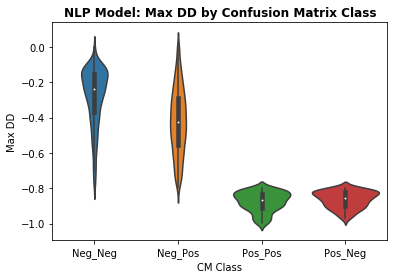

In [24]:
#graph 
import seaborn as sns
values = np.concatenate((dd_ff_arr, dd_ft_arr, dd_tt_arr, dd_tf_arr))
labels = ['Neg_Neg']*dd_ff_arr.shape[0]+['Neg_Pos']*dd_ft_arr.shape[0]+['Pos_Pos']*dd_tt_arr.shape[0]+['Pos_Neg']*dd_tf_arr.shape[0]
df_plot = pd.DataFrame(values, columns=['Max DD'])
df_plot['CM Class'] = labels
ax = sns.violinplot(x="CM Class", y="Max DD", data=df_plot, jitter=1.5)
ax = plt.title('NLP Model: Max DD by Confusion Matrix Class', fontweight='bold')


In [25]:
index_names = ['NLP', 'FIN', 'MKT']

dd_pred_true_all = [dd_pred_true_nlp, dd_pred_true_fin, dd_pred_true_mkt] 
dd_pred_false_all = [dd_pred_false_nlp, dd_pred_false_fin, dd_pred_false_mkt] 
dd_pred_mean_all = [dd_mean_nlp, dd_mean_fin, dd_mean_mkt] 

dict_port_dd_all = {'Pred Pos': dd_pred_true_all, 
                    'Pred Neg':dd_pred_false_all,
                    'Neg-Pos': np.array(dd_pred_false_all)
                                  -np.array(dd_pred_true_all),   
                     'All': dd_pred_mean_all}

df_port_dd_all = pd.DataFrame(dict_port_dd_all, index=index_names)
df_port_dd_all = df_port_dd_all.apply(lambda x: round(x,2))

print('\033[1m{:10s}\033[0m'.format('Portfolio Drawdown by Prediction: '))  
print('')
print(df_port_dd_all )

Portfolio Drawdown by Prediction: 

     Pred Pos  Pred Neg  Neg-Pos   All
NLP     -0.47     -0.29     0.18 -0.34
FIN     -0.47     -0.29     0.18 -0.35
MKT     -0.52     -0.29     0.23 -0.35


## 8. NLP Interpretation

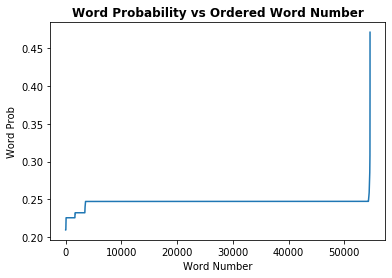

In [26]:
df_words_prob_all_max = np.sort(df_words_prob_final.max(axis=1).values)
_ = plt.plot(df_words_prob_all_max)
_ = plt.title('Word Probability vs Ordered Word Number', fontweight='bold')
_ = plt.ylabel('Word Prob')
_ = plt.xlabel('Word Number')


In [27]:
q = [0,25,50,75,99.9,100] 
vals = np.percentile(df_words_prob_all_max, q)

df_perc = pd.DataFrame(vals, index=q, columns=['Word Prob'])
df_perc = df_perc.apply(lambda x: round(x,2))
df_perc.columns.name = 'Percentile'

print('\033[1m{:10s}\033[0m'.format('Word Probability Percentiles'))  
print('')
print(df_perc)

Word Probability Percentiles

Percentile  Word Prob
0.0              0.21
25.0             0.25
50.0             0.25
75.0             0.25
99.9             0.28
100.0            0.47


In [28]:
largest_all = largest_all.apply(lambda x: round(x,2))
print('\033[1m{:10s}\033[0m'.format('Top words by Probability'))  
print('')
print(largest_all)

Top words by Probability

concern      0.47
lenders      0.40
going        0.37
heller       0.34
diabetic     0.34
             ... 
repaid       0.26
her          0.25
distant      0.25
resolving    0.25
subprime     0.24
Length: 67, dtype: float64


In [29]:
df_word_cat = pd.read_csv('top_words_nlp.csv')
df_word_cat
print('\033[1m{:10s}\033[0m'.format('Top words by Manually Sorted Category'))  
print('')
print(df_word_cat)

Top words by Manually Sorted Category

   Accounting/Credit Consultant Speak Negative Words  Healthcare Gender  \
0            concern       consultant    reassurance    diabetic   wife   
1            lenders      restructure          doubt       trial   girl   
2              going    repositioning          bears  enrollment    her   
3         projection        tightened          doubt         cvs    NaN   
4           infusion     implementing         teeter         NaN    NaN   
5               lien      effectuated     congestion         NaN    NaN   
6           dilution      elimination       endpoint         NaN    NaN   
7       subordinated         notified          ceded         NaN    NaN   
8             waived        resolving        distant         NaN    NaN   
9           revolver           regain      recission         NaN    NaN   
10            repaid            begun            NaN         NaN    NaN   
11          subprime          shorten            NaN         